```{contents}
```
## Execution Plan

An **Execution Plan** in LangGraph is the **concrete, runtime representation of how a graph will be executed**, derived from the static graph definition.
It specifies **what runs, in what order, under what conditions, with what state updates, and with what guarantees**.

In essence:

> **Graph = Design**
> **Execution Plan = How the design actually runs**

---

### **1. Why Execution Plans Exist**

LLM systems require:

* Deterministic ordering
* Controlled branching
* Safe looping
* Fault tolerance
* Observability
* Resumability

The execution plan provides these guarantees by transforming a graph into a **formal state-machine schedule**.

---

### **2. Conceptual Model**

```
Graph Definition
   ↓ compile()
Execution Plan
   ↓ invoke()
Runtime Execution
```

The execution plan is produced at **compile time** and used at **runtime**.

---

### **3. What the Execution Plan Contains**

| Component             | Description                      |
| --------------------- | -------------------------------- |
| Execution Steps       | Ordered list of executable units |
| Node Mapping          | Node → function/tool/agent       |
| Edge Rules            | Valid transitions                |
| Condition Evaluators  | Branching logic                  |
| State Reducers        | How updates merge                |
| Loop Controls         | Recursion & termination          |
| Parallel Schedules    | Concurrent execution map         |
| Retry Policies        | Failure recovery rules           |
| Checkpoint Boundaries | Persistence points               |
| Resource Constraints  | Time, token, cost budgets        |

---

### **4. How LangGraph Builds the Execution Plan**

During `compile()`:

1. **Validate graph structure**
2. **Infer execution order**
3. **Analyze cycles & termination**
4. **Build conditional routing tables**
5. **Attach state reducers**
6. **Insert checkpoint hooks**
7. **Construct fault-recovery metadata**
8. **Optimize scheduling**

```python
graph = builder.compile()
```

---

### **5. Runtime Behavior of the Execution Plan**

At `invoke()`:

1. Load initial state
2. Select entry node
3. Execute node
4. Apply state update
5. Evaluate transition rules
6. Schedule next step
7. Persist checkpoint
8. Repeat until END

This loop is driven entirely by the execution plan.

---

### **6. Example: Execution Plan in Action**

```python
class State(TypedDict):
    count: int

def inc(s): return {"count": s["count"] + 1}
def stop(s): return END if s["count"] >= 3 else "inc"

builder = StateGraph(State)
builder.add_node("inc", inc)
builder.set_entry_point("inc")
builder.add_conditional_edges("inc", stop, {"inc": "inc", END: END})

graph = builder.compile()
```

**Execution Plan Behavior**

| Step | Node | State   | Decision |
| ---- | ---- | ------- | -------- |
| 1    | inc  | count=1 | loop     |
| 2    | inc  | count=2 | loop     |
| 3    | inc  | count=3 | END      |

---

### **7. Advanced Features in Execution Plans**

| Feature           | Role                    |
| ----------------- | ----------------------- |
| Partial execution | Resume from checkpoint  |
| Parallel branches | Schedule multiple nodes |
| Dynamic routing   | Runtime graph shaping   |
| Backtracking      | Error recovery          |
| Timeout control   | Prevent hangs           |
| Recursion limit   | Prevent infinite loops  |

```python
graph.invoke(input, config={"recursion_limit": 20})
```

---

### **8. Production Significance**

| Problem         | Execution Plan Solution |
| --------------- | ----------------------- |
| Infinite loops  | Hard stop via limits    |
| Crashes         | Resume from checkpoint  |
| Cost overruns   | Budget constraints      |
| Hidden failures | Deterministic trace     |
| Scaling         | Parallel scheduling     |

---

### **9. Mental Model**

LangGraph’s execution plan is a **compiled program** for LLM systems:

> **Like a CPU instruction schedule for intelligent workflows**

It transforms abstract graphs into **predictable, debuggable, production-safe behavior**.


### Demonstration 

In [2]:
from typing import TypedDict
from langgraph.graph import StateGraph, END

class State(TypedDict):
    count: int

def increment(state: State) -> State:
    print(f"Executing: increment | count = {state['count']}")
    return {"count": state["count"] + 1}

def router(state: State):
    if state["count"] >= 3:
        print("Router decision: END")
        return END
    print("Router decision: increment")
    return "increment"

builder = StateGraph(State)

builder.add_node("increment", increment)
builder.set_entry_point("increment")

builder.add_conditional_edges(
    "increment",
    router,
    {"increment": "increment", END: END}
)

graph = builder.compile()


In [3]:
result = graph.invoke({"count": 0})
print("Final State:", result)

Executing: increment | count = 0
Router decision: increment
Executing: increment | count = 1
Router decision: increment
Executing: increment | count = 2
Router decision: END
Final State: {'count': 3}


In [4]:
result = graph.invoke(
    {"count": 0},
    config={"recursion_limit": 10}
)


Executing: increment | count = 0
Router decision: increment
Executing: increment | count = 1
Router decision: increment
Executing: increment | count = 2
Router decision: END


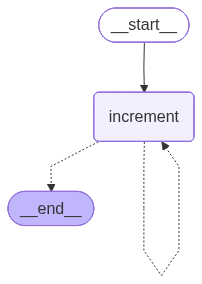

In [5]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())